<a href="https://colab.research.google.com/github/unoki/colabtest/blob/master/5_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第５章　オートエンコーダによる異常検知（プログラム）

第５章では、オートエンコーダによる異常検知のプログラムを実行します。


### 学習項目

1. 準備
2. データの準備
3. モデルの定義
4. パラメータの設定
5. トレーニング
6. 評価



### 使用するファイル
- 5_autoencoder.ipynb （このファイルです）
- data/ecg_data/down234_148000_152000.csv (訓練用データ)
- data/ecg_data/down234_152000_156000.csv (テスト用データ)

### データセット

- MIT-BIH Arrhythmia Databaseで公開されている心電図データのうち、ID234のデータを使用します。
- 元データのサンプリング周波数は360Hzです。２チャンネル分（MLII、V1）のデータが含まれています。
- 前処理として、サンプリング周波数を元データの半分の180Hzにするダウンサンプリング、トレンドの除去、および0から1の範囲へのスケーリングを行いました。
- 約65万点から、元データの148000点目から151999点までを訓練用に、152000から159999点までをテスト用に切り出し、それぞれ別のcsvファイルとしました。
- 各csvファイルには、約11秒（=2000point/180Hz）のデータが含まれます。csvファイルの1列目にはMLII、２列目にはV1の２列のデータからなります。



# 1. 準備
###  必要なライブラリの読み込み

- NumPy：モデル入力用のデータを作成するために使用します。
- Matplotlib：データの可視化に使用します。
- keras：ニューラルネットワークのためのライブラリです。



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


### バックエンドのグラフ識別子をリセット
- clear_session関数はバックエンドのTensorFlowのグラフを壊し，新たなものを作成します。 (https://keras.io/ja/backend/#clear_session)

In [0]:
K.clear_session()

### グラフのデフォルト表示サイズの変更

In [0]:
mpl.rcParams['figure.figsize'] = 15, 4

### カレントディレクトリの移動

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202


# 2. データの準備

### CSVファイルからデータを読み込む

- csvファイルから Pandas の DataFrame としてデータを読み込みます。
- 訓練用データを変数 train_df に、テストデータを変数 test_df に読み込んでみましょう。
- read_csv 関数を使います。
- 今回は、MLIIのみを使用するため、csvファイルの１列目だけを読み込みます。usecolsパラメータで読み込む列を指定します。1列目の指定は、0となります。

In [0]:
train_df = pd.read_csv('data/ecg_data/down234_148000_152000.csv', usecols=[0])
test_df = pd.read_csv('data/ecg_data/down234_152000_156000.csv', usecols=[0])
# train_df = pd.read_csv('data/ecg_data/scaled234_148000_152000.csv', usecols=[0])
# test_df = pd.read_csv('data/ecg_data/scaled234_152000_156000.csv', usecols=[0])

### データのサイズを確認してみましょう

- データの行と列の数を確認するには、shape を使います。
- shapeは関数ではないので、カッコが不要です。

In [0]:
train_df.shape

(2000, 1)

In [0]:
test_df.shape

(2000, 1)

### データの一部を表示してみましょう

- データの一部を表示するには、head関数や、tail関数を使います。
- head関数とtail関数は、表示する行数を引数にとります。（デフォルト値:5）

In [0]:
train_df.head()

,MLII
0,0.109128
1,0.088258
2,0.066945
3,0.058160
4,0.071976


In [0]:
test_df.head()

,MLII
0,0.164886
1,0.172314
2,0.177290
3,0.179869
4,0.187242


### グラフを表示してみましょう。

- matplotlibのplotメソッドを使います。

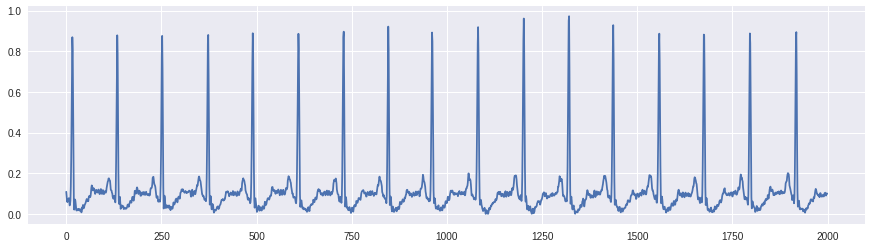

In [0]:
plt.plot(train_df)

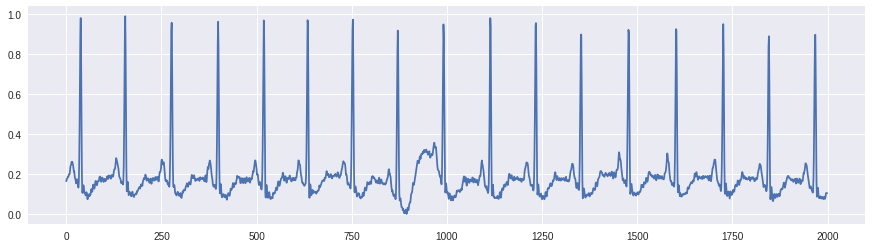

In [0]:
plt.plot(test_df)

###  モデル入力用データの作成

- 位置を1点ずつずらしながら指定されたウィンドウサイズのデータを順に切り出す関数を定義します。入力はDataFrameとウィンドウサイズ、出力はDataFrameとします。
- 訓練データを X_trainに、テストデータを X_testに代入します。
- head関数などで、内容を確認しておきましょう。

In [0]:
def subseq(x, w):
    seq = np.zeros((len(x) - w + 1, w))
    x_np = x.iloc[:, 0]
    for i in range(len(x) - w + 1):
        seq[i, :] = x_np[i:w+i]
    return pd.DataFrame(seq)

w_size = 100 # ウィンドウサイズ
X_train = subseq(train_df, w_size)
X_test = subseq(test_df, w_size)

In [0]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.109128,0.088258,0.066945,0.058160,0.071976,0.070855,0.074548,0.078003,0.061329,0.042165,...,0.113487,0.122801,0.109664,0.101539,0.098413,0.105368,0.117235,0.116513,0.100735,0.097379
1,0.088258,0.066945,0.058160,0.071976,0.070855,0.074548,0.078003,0.061329,0.042165,0.047974,...,0.122801,0.109664,0.101539,0.098413,0.105368,0.117235,0.116513,0.100735,0.097379,0.103948
2,0.066945,0.058160,0.071976,0.070855,0.074548,0.078003,0.061329,0.042165,0.047974,0.066254,...,0.109664,0.101539,0.098413,0.105368,0.117235,0.116513,0.100735,0.097379,0.103948,0.110467
3,0.058160,0.071976,0.070855,0.074548,0.078003,0.061329,0.042165,0.047974,0.066254,0.134413,...,0.101539,0.098413,0.105368,0.117235,0.116513,0.100735,0.097379,0.103948,0.110467,0.111930
4,0.071976,0.070855,0.074548,0.078003,0.061329,0.042165,0.047974,0.066254,0.134413,0.267482,...,0.098413,0.105368,0.117235,0.116513,0.100735,0.097379,0.103948,0.110467,0.111930,0.105785


# 3. モデルの定義

- Kerasのfunctional APIを使います。
- 各層のユニット数は、入力層100、隠れ層160、出力層100の3層のスパースオートエンコーダとします。
- 中間層の正則化項にL1出力正則化を用います。

In [0]:
l1=10e-7  # L1正則化のパラメータ
enc_dim = 160  # 隠れ層のユニット数

input_layer = Input(shape=(w_size,))
encoded = Dense(enc_dim, activation='relu', 
                activity_regularizer=regularizers.l1(l1))(input_layer)
decoded = Dense(w_size, activation='relu')(encoded)
autoencoder = Model(inputs=input_layer, 
                    outputs=decoded)

- summary関数で、モデルのが概要を確認できます。

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               16160     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               16100     
Total params: 32,260
Trainable params: 32,260
Non-trainable params: 0
_________________________________________________________________


# 4. パラメータの設定

- compile関数を用いてどのような学習処理を行なうかを設定を行います。
- 今回は、損失関数にbinary_crossentropy、最適化アルゴリズムにadadeltaを指定します。
- 細かいパラメータは、すべてデフォルトのままとしました。

In [0]:
autoencoder.compile(optimizer='adadelta',  
                    loss='binary_crossentropy')

# 5. トレーニング

- 入力データと教師データにX_trainを使って、モデルのトレーニング（学習）を行います。
- モデルをトレーニングには，fit関数を使います。
- fit関数には、トレーニングの入力データと教師データ、ミニバッチのサイズ(batch_size)、エポック数などを渡します。
- verbose=0とすると、トレーニング状況のログを画面に表示しません。

In [0]:
epochs = 5000
history = autoencoder.fit(X_train, 
                          X_train,
                          epochs=epochs,
                          batch_size=None,                    
                          verbose=0)

- fit関数の戻り値のhistoryオブジェクトには、各エポックでのloss関数の推移などが辞書型のデータとして記録されます。
- plot関数で表示してみましょう。

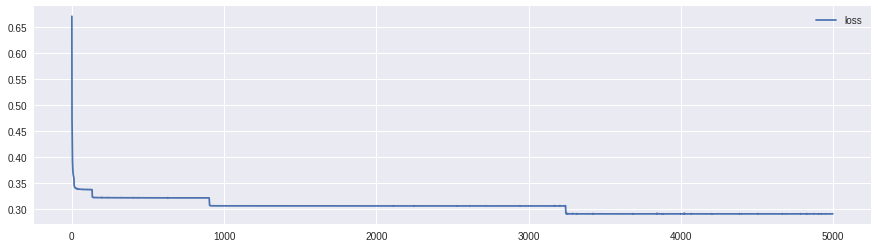

In [0]:
pd.DataFrame(history.history['loss'], columns=['loss']).plot()

# 6. 評価

### テストデータとオートエンコーダの出力との比較
- テストデータを使って、トレーニング済みモデルの評価を行います。
- predict関数を使い、トレーニング済みモデルにテストデータを適用します。predict関数の戻り値は、Numpy Arrayです。

In [0]:
decoded = pd.DataFrame(autoencoder.predict(X_test))

- 入力したテスト用データと、モデルの出力との距離として、各要素の差の二乗和の平方根を求めます。
- 結果をplotしてみましょう。

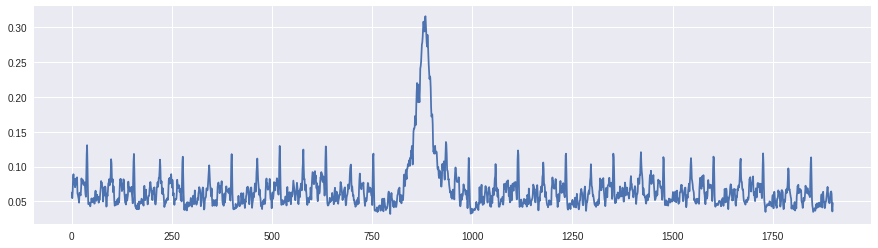

In [0]:
dist = np.sqrt( np.sum( (decoded - X_test)**2, axis=1))
dist.plot()

### 異常の判定
- 閾値の設定は、対象とするに問題領域に応じて適当に定める必要があります。
- 今回はテストデータに異常が含まれているという前提で、ピークの80%の値を閾値とし、閾値を超えるものを異常とみなします。

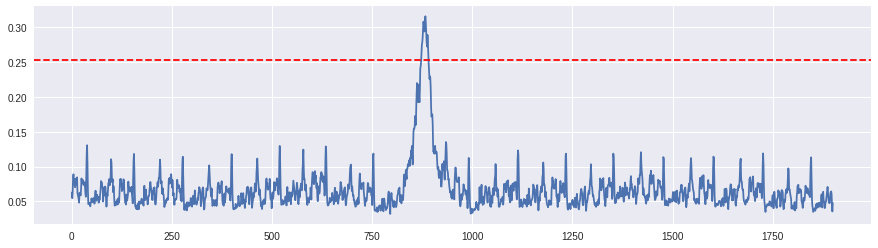

In [0]:
ax = dist.plot()
ax.axhline(y=dist.max() * 0.8, color='red', linestyle='--')

- 閾値を超える点のインデックスを取得してみます。

In [0]:
dist[dist > dist.max() * 0.8].index

Int64Index([873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885,
            886, 887, 888, 889, 890],
           dtype='int64')